In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
weather_df = pd.read_csv(r"C:\Users\Hello\DS Project\Cleaned_dataset\weather_data_with_hour.csv")


In [3]:
features = ['temperature_2m']
data = weather_df[features].values

In [4]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [5]:
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback, :])
        y.append(data[i + lookback, 0])  # Predicting temperature_2m
    return np.array(X), np.array(y)

In [6]:
lookback = 24  # 24 hours
X, y = create_sequences(scaled_data, lookback)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [8]:
# Hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 30
dropout_rate = 0.2

In [9]:
# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lookback, len(features))),
    Dropout(dropout_rate),
    LSTM(50, activation='relu'),
    Dropout(dropout_rate),
    Dense(1)
])

C:\Users\Hello\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

In [11]:
# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0353 - val_loss: 0.0032
Epoch 2/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0050 - val_loss: 0.0015
Epoch 3/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 4/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 5/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0024 - val_loss: 8.0991e-04
Epoch 6/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0018 - val_loss: 7.3518e-04
Epoch 7/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0016 - val_loss: 8.1789e-04
Epoch 8/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0013 - val_loss: 9.3369e-04
Epoch 9/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0012 - val_loss: 6.4000e-04
Epoch 10/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0011 - val_loss: 7.9664e-04
Epoch 11/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0011 - val_loss: 5.5420e-04
Epoch 12/30


In [12]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and true values
y_pred_rescaled = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((len(y_pred), len(features) - 1))], axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), len(features) - 1))], axis=1))[:, 0]

261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [13]:
# Calculate error metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 0.48
Mean Squared Error (MSE): 0.45
Root Mean Squared Error (RMSE): 0.67


In [14]:
# Create a DataFrame with the results
forecast_df = pd.DataFrame({
    "date": weather_df.iloc[-len(y_test):]['date_only'].reset_index(drop=True),
    "hour": weather_df.iloc[-len(y_test):]['hour'].reset_index(drop=True),
    "actual_temperature": y_test_rescaled,
    "predicted_temperature": y_pred_rescaled
})

# Round the temperature columns to two decimal places
forecast_df['actual_temperature'] = forecast_df['actual_temperature'].round(2)
forecast_df['predicted_temperature'] = forecast_df['predicted_temperature'].round(2)

# Save the predictions to a CSV file
file_name = f"lstm_temperature_forecast_bs{batch_size}_epochs{epochs}_lr{learning_rate}.csv"
forecast_df.to_csv(file_name, index=False)
print(f"Forecast saved to {file_name}")

Forecast saved to lstm_temperature_forecast_bs64_epochs30_lr0.001.csv


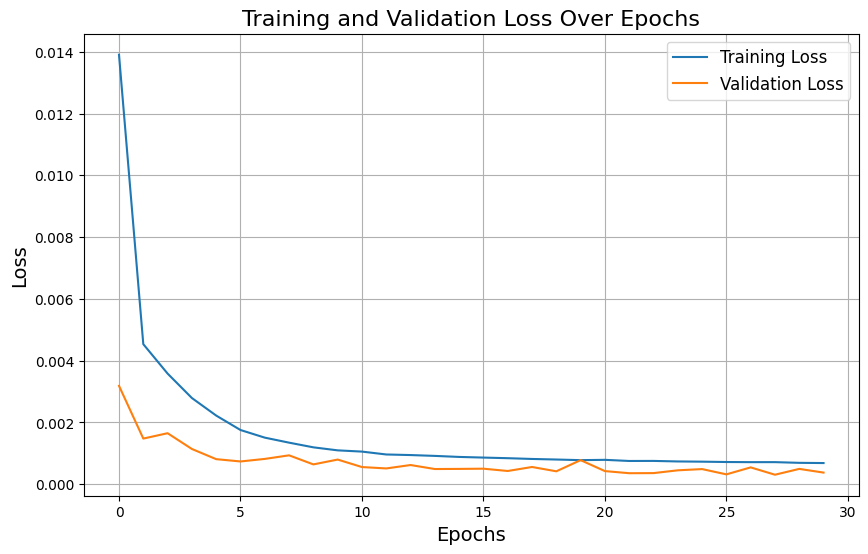

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss Over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [16]:
model.save("temperature_forecast_model.keras")
print("Model saved as temperature_forecast_model")

Model saved as temperature_forecast_model


In [17]:
import pickle
scaler_path = r"C:\Users\Hello\DS Project\temperature_scaler.pkl"
with open(scaler_path, 'wb') as file:
    pickle.dump(scaler, file)

print("Scaler saved to:", scaler_path)

Scaler saved to: C:\Users\Hello\DS Project\temperature_scaler.pkl
